In [1]:
#importing the neccessary libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import auc as auc_score, mean_absolute_error, mean_squared_error
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve,  accuracy_score, r2_score
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor


from collections import Counter 
from sklearn.preprocessing import label_binarize

### Reading in the dataset

In [2]:
#let's read in the data

cars = pd.read_csv('cars.csv', encoding = "ISO-8859-1")
cars.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


As we can see, there are some columns in the dataframe, which have sort of no real relevance to the actual price of the car. Let's remove those columns! After some thinking, I ended up chosing the following columns:
 - name
 - seller
 - offer type
 - gearbox
 - number of pictures
 - postalcode

In [3]:
#before we start working with the data, let's remove some columns, which are not very important:

cars_removed = cars.drop(columns=['name', 'seller', 'offerType', 'gearbox', 'nrOfPictures', 'postalCode', 'monthOfRegistration', 'dateCreated'])
cars_removed.head()

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,lastSeen
0,2016-03-24 11:52:17,480,test,NaN,1993,0,golf,150000,benzin,volkswagen,NaN,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,test,coupe,2011,190,NaN,125000,diesel,audi,ja,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,test,suv,2004,163,grand,125000,diesel,jeep,NaN,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,test,kleinwagen,2001,75,golf,150000,benzin,volkswagen,nein,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,test,kleinwagen,2008,69,fabia,90000,diesel,skoda,nein,2016-04-06 10:17:21


### Removing the nan data

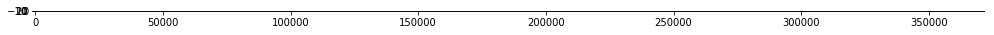

371528


In [4]:
#the usual first thing is searching for nan values

#visualizing the missing values

plt.figure(figsize=(17, 17))
plt.imshow(cars_removed.T.isna())
plt.show()

print(len(cars))

As it's seen, the figure of nan values is not very informative. This is because our dataset has 370k rows. Another thing we can do is checking the individual rows how many missing values it has. After this we have a better understanding of what data we should be removing and what we should be replacing with mean values.

In [5]:
#creating a numpy array from the dataset, because it makes the calculation significantly faster

cars_numpy = cars_removed.to_numpy()


indices = []

for i in range(0,len(cars_numpy)):
    if np.nan in list(cars_numpy[i]):
        indices.append(i)
        
print('The number of rows having nan values is:', len(indices))

The number of rows having nan values is: 106154


By the looks of it, third of the data have some missing values in them. There are some incredibly important information in the dataframe, which most of our models are going to be built on, and can not be replaced with the mean values of the dataset. If these are missing, we shall remove them. These are the following:
 - price
 - year of registration
 - power ps
 - kilometer
 - brand

In [6]:
#let's count the nan values in different columns!

indices_to_remove = []

for i in range(0,len(cars_numpy)):
    if np.nan in list(cars_numpy[i]):
        indices_to_remove.append(i)

cars_numpy_removed = np.delete(cars_numpy, indices_to_remove, axis=0)

After removing the nan values in each row, we are left with 265.374 data. 

### Removing the false data

Another anomali which I noticed when inspecting the data was that there were many false values by the horsepower column. AFtert doing some research, I came to the conculsion that the highest horsepower was around 500 in 2016. This means that everything above this value must be eliminiated from the rows. After some thinking, I decided to eliminate all the cars above 300 horsepower from the dataset. I checked the length of the list of these cars and there are only 6146. Since this is an insignificant amount of data considering the 371528 total cars, this will not decrease the accuracy of our model. However, there were many car with horsepower = 0. This shall be removed from the dataset too.

In [7]:
#creating a list to store the false horsepowers

false_horsepower_indices = []

#going through the data and saving the false horsepowers

for i in range(0,len(cars_numpy_removed)):
    if int(cars_numpy_removed[i][5]) > 300 or int(cars_numpy_removed[i][5]) < 50:
        false_horsepower_indices.append(i)
        
#let's remove these rows from the cars_numpy

deleted_horsepower_cars = np.delete(cars_numpy_removed, false_horsepower_indices, axis=0)
        
print('There are', len(false_horsepower_indices), 'false horsepower data in the dataset.')
print('These are removed from the cars_numpy_removed at this point.')
print('The old dataset had a length of', len(cars_numpy_removed))
print('The new dataset has a length of', len(deleted_horsepower_cars))

There are 20813 false horsepower data in the dataset.
These are removed from the cars_numpy_removed at this point.
The old dataset had a length of 265374
The new dataset has a length of 244561


When checking the data, I saw that there are some false prices too. When somebody didn't want to give an exact price, they just wrote '99999999' or '12345678'. These datapoints shall be removed too. After some insepction, I decided to remove all prices above 225000 dollars.

In [8]:
#creating a list to store the false prices

false_speed_indices = []

#going through the data and saving the false prices

for i in range(0,len(deleted_horsepower_cars)):
    if int(deleted_horsepower_cars[i][1]) > 80000 or int(deleted_horsepower_cars[i][1]) < 1000:
        false_speed_indices.append(i)
        
#let's remove these rows from the dataset

deleted_prices = np.delete(deleted_horsepower_cars, false_speed_indices, axis=0)
        
print('There are', len(false_speed_indices), 'false price data in the dataset.')
print('These are removed from the deleted_horsepower_cars at this point.')
print('The old dataset had a length of', len(deleted_horsepower_cars))
print('The new dataset has a length of', len(deleted_prices))

There are 35901 false price data in the dataset.
These are removed from the deleted_horsepower_cars at this point.
The old dataset had a length of 244561
The new dataset has a length of 208660


Let's check the year of registration for the cars! There might be some false values there too.

In [9]:
#putting the year of registration to a list and checking the maximum and minimum values

car_year_reg = deleted_prices[:,4]

np.max(car_year_reg), np.min(car_year_reg)

(2018, 1931)

Of course ther are some false values here too. Let's remove these! We shall remove everything after 2016 -s ince the dataset was created then -  and (after some thinking and checking the data) before 1950.

In [10]:
#creating a list to store the false prices

false_date_indices = []

#going through the data and saving the false prices

for i in range(0,len(deleted_prices)):
    if int(deleted_prices[i][4]) < 1950 or int(deleted_prices[i][4]) > 2016:
        false_date_indices.append(i)
        
#let's remove these rows from the dataset

deleted_dates = np.delete(deleted_prices, false_date_indices, axis=0)
        
print('There are', len(false_date_indices), 'false date data in the dataset.')
print('These are removed from the deleted_prices at this point.')
print('The old dataset had a length of', len(deleted_prices))
print('The new dataset has a length of', len(deleted_dates))

There are 21 false date data in the dataset.
These are removed from the deleted_prices at this point.
The old dataset had a length of 208660
The new dataset has a length of 208639


The last thing we have to check is the kilometer driven by the car! 

In [11]:
#putting the kilometer to a list and checking the maximum and minimum values

car_km = deleted_dates[:,7]

np.max(car_km), np.min(car_km)

(150000, 5000)

By the looks of it, there is nothing to remove here!

In [12]:
#renaming the dataset and checking the dimensions:

cars_removed_false_values = deleted_dates

print('The final length of the dataset is:', len(cars_removed_false_values))

The final length of the dataset is: 208639


### Str to num values

#### Brand

In the following, I'll create a very simple model. I'll first predict the prices of cars only from the kilometer, the power and the type of car. For this, I'll have to create numerical values of the car types. Let's see first how many car types we have!

In [13]:
#creating a dict from the number of cars from each brand

car_types_keys = Counter(cars_removed['brand']).keys()
car_types_counter = list(car_types_keys)

print('The number of car types:', len(car_types_counter))

The number of car types: 40


In [14]:
#creating a list for the numerical values of the model

car_types_num_counter = list(range(0,40))
car_types_str = cars_removed_false_values[:,9]

#replacing the str values with the car type numerical values

car_types_num = []

for i in range(0,len(car_types_str)):
    index_of_type = car_types_counter.index(car_types_str[i])
    car_types_num.append(index_of_type)

#### Damage

In [15]:
#if there is a damage, we will mark it with 1
#if there is not damage, we will mark it with 0 

damage_str = cars_removed_false_values[:,10]
dmg_num = []

for i in range(0,len(damage_str)):
    if damage_str[i] == 'ja':
        dmg_num.append(0)
    elif damage_str[i] == 'nein':
        dmg_num.append(1)

#### Vehicle type

In [16]:
#creating a dict from the number of cars from each vehichle type

vehicle_types_keys = Counter(cars_removed_false_values[:,3]).keys()
vehicle_types_counter = list(vehicle_types_keys)

print('The number of vehichle types:', len(vehicle_types_counter))
print(vehicle_types_counter)

The number of vehichle types: 8
['kleinwagen', 'cabrio', 'limousine', 'kombi', 'suv', 'bus', 'coupe', 'andere']


In [17]:
#creating a list for the numerical values of the model

vehicle_types_num_counter = list(range(0,8))
vehicle_types_str = cars_removed_false_values[:,3]

#replacing the str values with the car type numerical values

vehicle_types_num = []

for i in range(0,len(vehicle_types_str)):
    index_of_type = vehicle_types_counter.index(vehicle_types_str[i])
    vehicle_types_num.append(index_of_type)

#### Difference between dates

In [18]:
date_of_add = cars_removed_false_values[:,0]
last_seen_date = cars_removed_false_values[:,11]

In [19]:
date_of_add[0], last_seen_date[0]

('2016-03-17 16:54:04', '2016-03-17 17:40:17')

### Creating the x and y- and the correlation matrices

Now that we transformed the strings to numericals, we can create a very simple model! Let's do this by creating some lists to store the data.

In [20]:
#creating lists of the important values

car_price = cars_removed_false_values[:,1]
car_year_reg = cars_removed_false_values[:,4]
car_power = cars_removed_false_values[:,5]
car_kilometer = cars_removed_false_values[:,7]

#another scaling method which we can do is subtract the lowest values from each row (whenever it's non zero)

car_year_reg_sub = car_year_reg - np.min(car_year_reg)
car_power_sub = car_power - np.min(car_power)
car_kilometer_sub = car_kilometer - np.min(car_kilometer)

#creating matrices of the lists

x_dataframe = np.array([car_price, car_kilometer_sub, car_year_reg_sub, car_power_sub, car_types_num, vehicle_types_num, dmg_num])
x = np.array([car_kilometer_sub, car_year_reg_sub, car_power_sub, car_types_num, vehicle_types_num, dmg_num])

x_dataframe = x_dataframe.T
x = x.T

y = car_price

In [21]:
#let's take a look at the shape of the data!

df = pd.DataFrame(data=x_dataframe, columns=["Price", "Kilometer", "Registration year", "Horsepower", "Brand", "Vehichle type", "Damage"])
df = df.astype(int)
df.head()

,Price,Kilometer,Registration year,Horsepower,Brand,Vehichle type,Damage
0,1500,145000,51,25,0,0,1
1,3600,85000,58,19,3,0,1
2,2200,145000,54,59,5,1,1
3,2000,145000,54,55,7,2,1
4,2799,145000,55,90,0,3,0


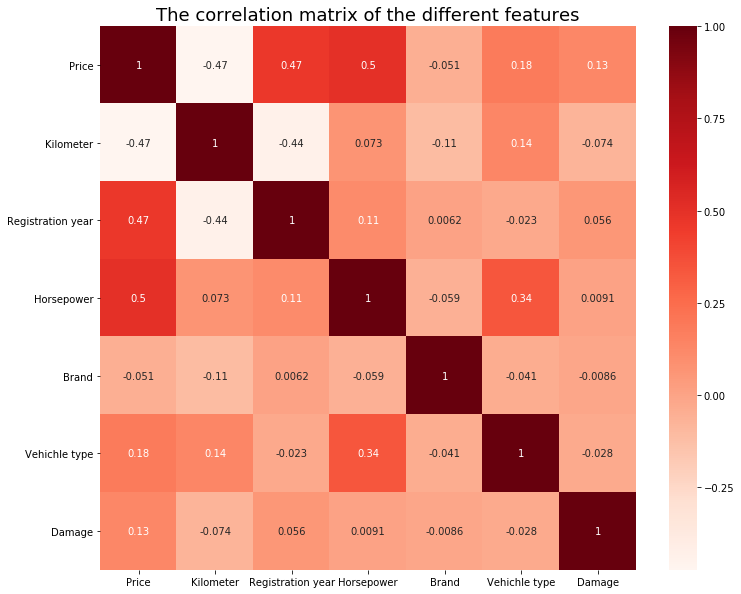

In [22]:
#Using Pearson Correlation

plt.figure(figsize=(12,10))
plt.title('The correlation matrix of the different features', fontsize = 18)
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('correlation.jpg', dpi = 500)
plt.show()

### Splitting and scaling the dataset

At this point of the exercise, I successfully created the matrix of the data, from which I'd like to predict the prices of the cars. Let's scale the values and create test, train splits! I chose to scale the dataset according to the train dataset's mean and std.

In [23]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

C:\Users\haffn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\haffn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
#splitting the dataset

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#checking the dimensions

len(X_train), len(y_train), len(X_test), len(y_test)

(166911, 166911, 41728, 41728)

### Creating the model

ExtraTreesRegressor implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference sklearn documentation.

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Reference sklearn documentation.

In [25]:
#creating the model 

reg = ExtraTreesRegressor(n_estimators=150, random_state=0, max_features = 'sqrt', bootstrap = True).fit(X_train, y_train)

#predicting the test dataset

y_pred_test = reg.predict(X_test)

In [26]:
#calculating the scores

tree_score = reg.score(X_test, y_test)
relative_error = mean_absolute_error(y_test, y_pred_test)*len(y_test)/sum(abs(y_test))
relative_mean_squared = (mean_squared_error(y_test, y_pred_test))**0.5

#printing the result

print('The R^2 score of the prediction:', round(tree_score,3))
print('Relative error between predicted and measured y values:', round(relative_error,3))
print('RMSE between predicted y_pred and measured y_meas values:', round(relative_mean_squared,3))

The R^2 score of the prediction: 0.88
Relative error between predicted and measured y values: 0.183
RMSE between predicted y_pred and measured y_meas values: 2457.283


After trying out all the different $max\_features$ parameters, I ended up using the 'sqrt' of n_features. There is also an option about using bootstrap method or not. If this is off, the whole sample is used when building the tree. The $R^2$ slighlty increased when I set the value of $bootstrap$ to $True$. Let's plot the predicted values in the function of the actual test values!

### Plotting the results

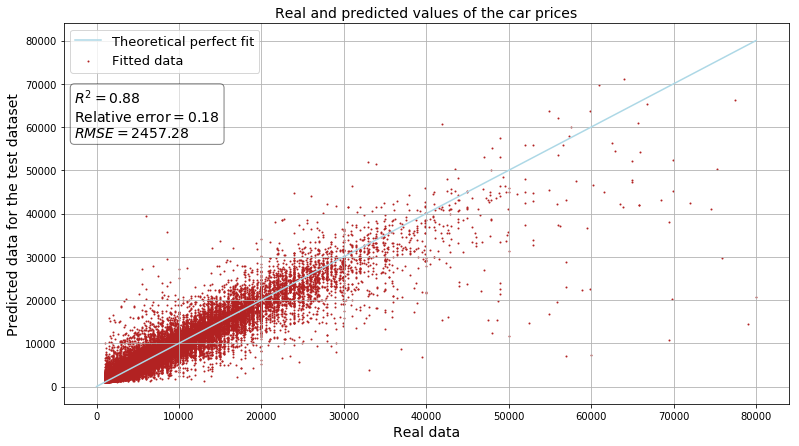

In [27]:
#the distances between the real and predicted data are seen in the following graphs:

#creating linear function

y_ideal = list(range(0,np.max(y_test)))

fig, ax = plt.subplots(figsize=(13,7))
#plt.figure(figsize=(13,7))

plt.scatter(y_test, y_pred_test, color = 'firebrick', s = 1, label = 'Fitted data')
plt.plot(y_ideal, y_ideal, color = 'lightblue', label = 'Theoretical perfect fit')
plt.ylabel('Predicted data for the test dataset', fontsize = 14)
plt.xlabel('Real data', fontsize = 14)
plt.title('Real and predicted values of the car prices', fontsize = 14)

text1 = 'R^2 score: ' + str(round(tree_score,4))
text2 = 'Relative error: ' + str(round(relative_error,4))
text3 = 'RMSE: ' + str(round(relative_mean_squared,4))

textstr = '\n'.join((
    r'$R^2 = %.2f$' % (round(tree_score,4), ),
    r'Relative error$=%.2f$' % (round(relative_error,4), ),
    r'$RMSE=%.2f$' % (round(relative_mean_squared,4), )))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.015, 0.83, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#plt.text(-3000, 67000, text1, fontsize=13)
#plt.text(-3000, 62000, text2, fontsize=13)
#plt.text(-3000, 57000, text3, fontsize=13)

plt.grid()
plt.legend(prop={'size': 13})
#plt.savefig('car_prices_fit.jpg', dpi = 800)

plt.show()

As it's seen, the ExtraTreesRegressor successfully and quite accurately predicted the test dataset. We can plot the residual plot now, which is the difference between the prediction and the actual y values.

In [50]:
y_below_10_test = []
y_below_25_test = []
y_below_50_test = []
y_below_100_test = []

dist_below_10_test = []
dist_below_25_test = []
dist_below_50_test = []
dist_below_100_test = []

under_5_perc = 0
under_15_perc = 0
under_30_perc = 0
under_50_perc = 0

for i in range(0,len(y_test)):
    
    #the distance between the real and predicted values
    
    dist_pred_real = abs(y_test[i] - y_pred_test[i])
    
    #calculating the percentage of accuracies
    
    if y_test[i]*0.05 > dist_pred_real:
        under_5_perc += 1
        
    if y_test[i]*0.15 > dist_pred_real:
        under_15_perc += 1
        
    if y_test[i]*0.30 > dist_pred_real:
        under_30_perc += 1
        
    if y_test[i]*0.50 > dist_pred_real:
        under_50_perc += 1
        
    #filling up the lists with the appropriate values for the plotting
    
    if y_test[i] < 10000:
        y_below_10_test.append(y_test[i])
        dist_below_10_test.append(dist_pred_real)
        
    elif y_test[i] > 10000 and y_test[i] < 25000:
        y_below_25_test.append(y_test[i])
        dist_below_25_test.append(dist_pred_real)
        
    elif y_test[i] > 25000 and y_test[i] < 50000:
        y_below_50_test.append(y_test[i])
        dist_below_50_test.append(dist_pred_real)
        
    elif y_test[i] > 50000:
        y_below_100_test.append(y_test[i])
        dist_below_100_test.append(dist_pred_real)

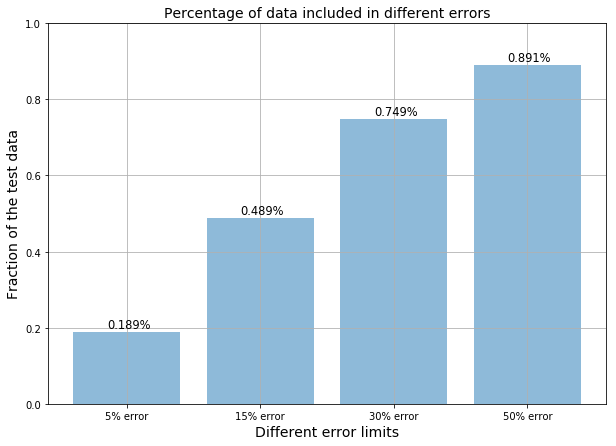

In [76]:
#calculating the percentages and plotting the barchart

perc_5 = under_5_perc/len(y_test)
perc_15 = under_15_perc/len(y_test)
perc_30 = under_30_perc/len(y_test)
perc_50 = under_50_perc/len(y_test)

objects = ('5% error', '15% error', '30% error', '50% error')
y_pos = np.arange(len(objects))
performance = [perc_5, perc_15, perc_30, perc_50]

plt.figure(figsize = (10,7))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Fraction of the test data', fontsize = 14)
plt.xlabel('Different error limits', fontsize = 14)
plt.title('Percentage of data included in different errors', fontsize = 14)

plt.ylim(0,1)

for i, v in enumerate(performance):
    text = str(round(v,3)) + '%'
    plt.text(i - .15, v + .01, text, fontsize = 11.5)#, color='blue', fontweight='bold')

plt.grid()

plt.savefig('barchart.jpg', dpi = 800)

plt.show()

In [46]:
#creating a slope for the plot

list_of_values = np.array(range(0,80000))
list_of_values_20 = list_of_values*0.3

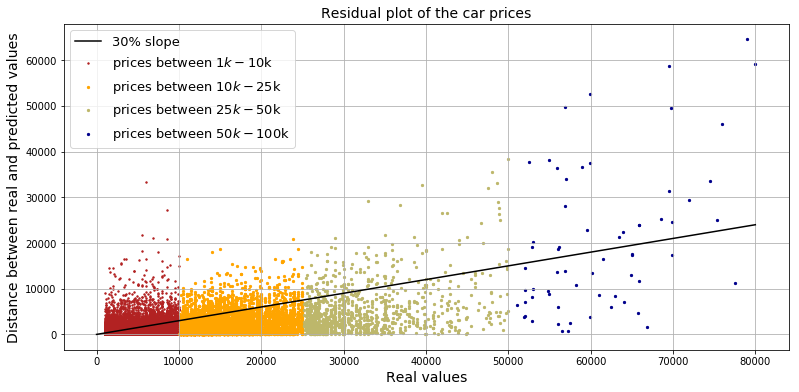

In [49]:
#the distances between the real and predicted data are seen in the following graphs:

plt.figure(figsize=(13,6))

plt.scatter(y_below_10_test, dist_below_10_test, color = 'firebrick', s = 2, label = 'prices between $1k-$10k')
plt.scatter(y_below_25_test, dist_below_25_test, color = 'orange', s = 5, label = 'prices between $10k-$25k')
plt.scatter(y_below_50_test, dist_below_50_test, color = 'darkKhaki', s = 5, label = 'prices between $25k-$50k')
plt.scatter(y_below_100_test, dist_below_100_test, color = 'darkblue', s = 5, label = 'prices between $50k-$100k')

plt.plot(list_of_values, list_of_values_20, color = 'black', label = '30% slope')

plt.ylabel('Distance between real and predicted values', fontsize = 14)
plt.xlabel('Real values', fontsize = 14)
plt.title('Residual plot of the car prices', fontsize = 14)

plt.grid()
plt.legend(prop={'size': 13})
plt.savefig('residual_car_prices.jpg', dpi = 800)

plt.show()